### Import necessary libraries

In [124]:
# Data representation and computation
import pandas as pd  
import numpy as np  
pd.options.display.float_format = '{:20,.4f}'.format

# Graph plotting
import matplotlib.pyplot as plt  
import seaborn as sns

# Data splitting, feature engg., and pipeline to train machine learning models
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score


# Machine learning models
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
from xgboost import XGBClassifier

# Miscellaneous
import warnings
from prettytable import PrettyTable

# Declaration
warnings.filterwarnings('ignore')
%precision 2
%matplotlib inline
sns.set(font_scale=1)

### Load Data

In [69]:
import json
with open(r"data/transactions.txt","r+") as f:
    llst_transaction_records = f.readlines()
llst_transaction_records = [json.loads(item) for item in llst_transaction_records]
ldf_training_dataset = pd.DataFrame(llst_transaction_records)

ldf_training_dataset['transactionDateTime'] = pd.to_datetime(ldf_training_dataset['transactionDateTime'])

In [70]:
ldf_training_dataset.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,02,...,,0.0,,,,False,,,False,False
1,737265056,737265056,5000.0,5000.0,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,...,,0.0,,,,True,,,False,False
2,737265056,737265056,5000.0,5000.0,2016-11-08 09:18:39,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
3,737265056,737265056,5000.0,5000.0,2016-12-10 02:14:50,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
4,830329091,830329091,5000.0,5000.0,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,...,,0.0,,,,True,,,False,False


## 1- Describe the structure of the date (statistical summary: number of records, counting max, min, null,...)

##### Statistical summary

In [71]:
print("Number of records: "+str(len(ldf_training_dataset)))

Number of records: 786363


In [72]:
ldf_training_dataset.describe()

,creditLimit,availableMoney,transactionAmount,currentBalance
count,786363.000000,786363.000000,786363.000000,786363.000000
mean,10759.464459,6250.725369,136.985791,4508.739089
std,11636.174890,8880.783989,147.725569,6457.442068
min,250.000000,-1005.630000,0.000000,0.000000
25%,5000.000000,1077.420000,33.650000,689.910000
50%,7500.000000,3184.860000,87.900000,2451.760000
75%,15000.000000,7500.000000,191.480000,5291.095000
max,50000.000000,50000.000000,2011.540000,47498.810000


In [73]:
ldf_training_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
accountNumber               786363 non-null object
customerId                  786363 non-null object
creditLimit                 786363 non-null float64
availableMoney              786363 non-null float64
transactionDateTime         786363 non-null datetime64[ns]
transactionAmount           786363 non-null float64
merchantName                786363 non-null object
acqCountry                  786363 non-null object
merchantCountryCode         786363 non-null object
posEntryMode                786363 non-null object
posConditionCode            786363 non-null object
merchantCategoryCode        786363 non-null object
currentExpDate              786363 non-null object
accountOpenDate             786363 non-null object
dateOfLastAddressChange     786363 non-null object
cardCVV                     786363 non-null object
enteredCVV                  786363 non-null object
cardLast4Di

In [74]:
ldf_training_dataset.isna().sum()

accountNumber               0
customerId                  0
creditLimit                 0
availableMoney              0
transactionDateTime         0
transactionAmount           0
merchantName                0
acqCountry                  0
merchantCountryCode         0
posEntryMode                0
posConditionCode            0
merchantCategoryCode        0
currentExpDate              0
accountOpenDate             0
dateOfLastAddressChange     0
cardCVV                     0
enteredCVV                  0
cardLast4Digits             0
transactionType             0
echoBuffer                  0
currentBalance              0
merchantCity                0
merchantState               0
merchantZip                 0
cardPresent                 0
posOnPremises               0
recurringAuthInd            0
expirationDateKeyInMatch    0
isFraud                     0
dtype: int64

## 2- Plotting histogram of "transactionAmount" column

##### Plotting bar-chart of "isFraud`" column.

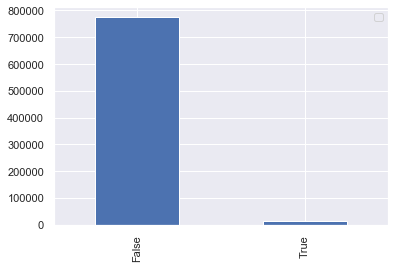

In [75]:
ldf_temp = ldf_training_dataset.isFraud.value_counts().to_frame("_count")
ldf_temp.plot(kind="bar")

##### Plotting histogram of "transactionAmount" column.

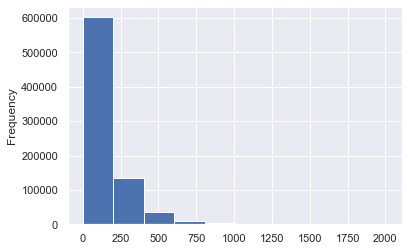

In [76]:
ldf_training_dataset['transactionAmount'].plot.hist()

## 3.1 - Identifying Duplicate Transactions

#### To identify Multi-swipe transactions, using groupby and diff to check whether the difference between successive transactions is less than 300 seconds (5 minutes).

In [77]:
ldf_training_dataset['IsDuplicate'] = (ldf_training_dataset.sort_values(['transactionDateTime'])
                       .groupby(['accountNumber', 'transactionAmount', 'merchantName'], sort=False)['transactionDateTime']
                       .diff()
                       .dt.total_seconds()
                       .lt(300))

#### If the Account Number, Transaction Amount, Merchant Name are same and the transaction happened within 300 seconds, the first transaction is considered as Normal, all the others are considered as Multi-swipe

In [78]:
ldf_training_dataset.IsDuplicate.value_counts().to_frame("Count")

,Count
False,772960
True,13403


#### To identify Reversed transactions, using the Transaction Type column

In [79]:
ldf_training_dataset.transactionType.value_counts().to_frame("Count")

,Count
PURCHASE,745193
REVERSAL,20303
ADDRESS_VERIFICATION,20169
,698


## 3.2 -Estimating the total number and dollar amount of Normal & Duplicate Transactions.

In [80]:
Model_Accuracy = PrettyTable()
Model_Accuracy.field_names = ["","No. of Transactions", "Doller Amount"]
Model_Accuracy.align[""] = "r"
ldf_training_dataset_normal = ldf_training_dataset[(ldf_training_dataset['transactionType']!="REVERSAL") &
                                           (ldf_training_dataset['IsDuplicate'] == False)]

Model_Accuracy.add_row(["Normal (Excluding Duplicates)",len(ldf_training_dataset_normal), 
                        round(sum(ldf_training_dataset_normal['transactionAmount']))])
print("\nA - Normal (Excluding Duplicates)")
print(Model_Accuracy)


A - Normal (Excluding Duplicates)
+-------------------------------+---------------------+---------------+
|                               | No. of Transactions | Doller Amount |
+-------------------------------+---------------------+---------------+
| Normal (Excluding Duplicates) |        758380       |   103794758   |
+-------------------------------+---------------------+---------------+


In [81]:
# =====================================================================================================

Model_Accuracy = PrettyTable()
Model_Accuracy.field_names = ["","No. of Transactions", "Doller Amount"]
Model_Accuracy.align[""] = "r"
ldf_training_dataset_rev = ldf_training_dataset[ldf_training_dataset["transactionType"] == "REVERSAL"]
ldf_training_dataset_multi_swipe = ldf_training_dataset[(ldf_training_dataset['transactionType']!="REVERSAL") &
                                           (ldf_training_dataset['IsDuplicate'] == True)]

Model_Accuracy.add_row(["Reversal",len(ldf_training_dataset_rev), 
                        round(sum(ldf_training_dataset_rev['transactionAmount']))])
Model_Accuracy.add_row(["Multi-Swipe",len(ldf_training_dataset_multi_swipe), 
                        round(sum(ldf_training_dataset_multi_swipe['transactionAmount']))])
Model_Accuracy.add_row(["","----","----"])
Model_Accuracy.add_row(["Reversal + Multi-Swipe",int(len(ldf_training_dataset_rev)+
                                                            len(ldf_training_dataset_multi_swipe)),
                        round(sum(ldf_training_dataset_rev['transactionAmount']))+
                       round(sum(ldf_training_dataset_multi_swipe['transactionAmount']))])

print("\nB - Duplicates(Reversal + Multi-Swipe)")
print(Model_Accuracy)


B - Duplicates(Reversal + Multi-Swipe)
+------------------------+---------------------+---------------+
|                        | No. of Transactions | Doller Amount |
+------------------------+---------------------+---------------+
|               Reversal |        20303        |    2821792    |
|            Multi-Swipe |         7680        |    1104007    |
|                        |         ----        |      ----     |
| Reversal + Multi-Swipe |        27983        |    3925799    |
+------------------------+---------------------+---------------+


In [82]:
# =====================================================================================================

Model_Accuracy = PrettyTable()
Model_Accuracy.field_names = ["","No. of Transactions", "Doller Amount"]
Model_Accuracy.align[""] = "r"

Model_Accuracy.add_row(["A + B",len(ldf_training_dataset_normal)+
                                    (len(ldf_training_dataset_rev)+len(ldf_training_dataset_multi_swipe)),
                        (round(sum(ldf_training_dataset_rev['transactionAmount']))+
                       round(sum(ldf_training_dataset_multi_swipe['transactionAmount'])))+
                       round(sum(ldf_training_dataset_normal['transactionAmount']))])
print("\nC = A + B (Normal & Duplicate both)")
print(Model_Accuracy)


C = A + B (Normal & Duplicate both)
+-------+---------------------+---------------+
|       | No. of Transactions | Doller Amount |
+-------+---------------------+---------------+
| A + B |        786363       |   107720557   |
+-------+---------------------+---------------+


## 4 - Modeling

### Sampling to make the dataset balanced

In [83]:
ldf_training_dataset.isFraud.value_counts().to_frame("Count")

,Count
False,773946
True,12417


__Since the number of isFraud=True cases is very low as compared to the isFraud=False cases, we will take out a balanced sample by keeping all the records of isFraud=True cases and taking only 18,000 records of isFraud=False cases.__

In [84]:
ldf_training_dataset_2 = ldf_training_dataset.groupby('isFraud', group_keys=False).apply(lambda x:x.sample(min(len(x), 18000)))
ldf_training_dataset_2 = ldf_training_dataset_2.reset_index(drop=True)
print("Number of records after under-sampling: "+str(len(ldf_training_dataset_2.isFraud)))

Number of records after under-sampling: 30417


In [85]:
ldf_training_dataset_2.isFraud.value_counts().to_frame("Count")

,Count
False,18000
True,12417


##### Removing the duplicate transactions (Reversal and Multi-swipe)

In [86]:
ldf_training_dataset_3 = ldf_training_dataset_2[(ldf_training_dataset_2['transactionType']!="REVERSAL") &
                                           (ldf_training_dataset_2['IsDuplicate'] == False)]

## 4.1 - Predictive model to determine whether a given transaction will be fraudulent or not

#### Select input variables

In [87]:
input_col = ['creditLimit', 'transactionAmount', 'merchantCountryCode',
            'merchantCategoryCode','cardPresent', 'posEntryMode', 'posConditionCode', 
            'acqCountry', 'currentBalance', 'isFraud']
ldf_training_dataset_clf = ldf_training_dataset_3[input_col]

#### Convert categorical columns to dummy variables 

In [88]:
feature_dummy = pd.get_dummies(ldf_training_dataset_clf["creditLimit"], prefix='FRAUD_CLASSIFIER_creditLimit')
ldf_training_dataset_clf = pd.concat([ldf_training_dataset_clf, feature_dummy], axis = 1)
ldf_training_dataset_clf.drop("creditLimit", axis=1, inplace=True)

feature_dummy = pd.get_dummies(ldf_training_dataset_clf["merchantCountryCode"], prefix='FRAUD_CLASSIFIER_merchantCountryCode')
ldf_training_dataset_clf = pd.concat([ldf_training_dataset_clf, feature_dummy], axis = 1)
ldf_training_dataset_clf.drop("merchantCountryCode", axis=1, inplace=True)

feature_dummy = pd.get_dummies(ldf_training_dataset_clf["merchantCategoryCode"], prefix='FRAUD_CLASSIFIER_merchantCategoryCode')
ldf_training_dataset_clf = pd.concat([ldf_training_dataset_clf, feature_dummy], axis = 1)
ldf_training_dataset_clf.drop("merchantCategoryCode", axis=1, inplace=True)

feature_dummy = pd.get_dummies(ldf_training_dataset_clf["cardPresent"], prefix='FRAUD_CLASSIFIER_cardPresent')
ldf_training_dataset_clf = pd.concat([ldf_training_dataset_clf, feature_dummy], axis = 1)
ldf_training_dataset_clf.drop("cardPresent", axis=1, inplace=True)

feature_dummy = pd.get_dummies(ldf_training_dataset_clf["posEntryMode"], prefix='FRAUD_CLASSIFIER_posEntryMode')
ldf_training_dataset_clf = pd.concat([ldf_training_dataset_clf, feature_dummy], axis = 1)
ldf_training_dataset_clf.drop("posEntryMode", axis=1, inplace=True)

feature_dummy = pd.get_dummies(ldf_training_dataset_clf["posConditionCode"], prefix='FRAUD_CLASSIFIER_posConditionCode')
ldf_training_dataset_clf = pd.concat([ldf_training_dataset_clf, feature_dummy], axis = 1)
ldf_training_dataset_clf.drop("posConditionCode", axis=1, inplace=True)

feature_dummy = pd.get_dummies(ldf_training_dataset_clf["acqCountry"], prefix='FRAUD_CLASSIFIER_acqCountry')
ldf_training_dataset_clf = pd.concat([ldf_training_dataset_clf, feature_dummy], axis = 1)
ldf_training_dataset_clf.drop("acqCountry", axis=1, inplace=True)

#### Train Test & Validation Split

In [97]:
y = ldf_training_dataset_clf.isFraud
X = ldf_training_dataset_clf.drop("isFraud", axis=1)

my_tags = y

In [98]:
# splitting X and y into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123, shuffle=True)

In [99]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(23459, 53)
(23459,)
(5865, 53)
(5865,)


### Algorithm 1: Support Vector Machines

Reason for choosing SVM:
* SVM can easily handle multiple continuous and categorical variables. 
* It is known for its kernel trick to handle nonlinear input spaces
* SVM constructs a hyperplane in multidimensional space to separate different classes. 
* SVM generates optimal hyperplane in an iterative manner, which is used to minimize an error.

##### Define a model

In [89]:
clf_svm = SGDClassifier(
        loss='hinge',
        penalty='l2',
        alpha=1e-3,
        random_state=42,
        max_iter=5,
        tol=None)

##### Fit model on training data

In [102]:
svm_model = clf_svm.fit(X_train, y_train)

##### Predicting on test data

In [103]:
svm_y_pred = svm_model.predict(X_test)

##### Model evaluation metrics - Accuracy, Precision, Recall, F1 Score

In [95]:
confusion_matrix(y_test,svm_y_pred)

array([[3345,  124],
       [2197,  193]], dtype=int64)

In [109]:
print('Accuracy %s' % accuracy_score(svm_y_pred, y_test))
print('Precision:', precision_score(svm_y_pred, y_test, average='weighted'))
print('Recall:', recall_score(svm_y_pred, y_test,average='weighted'))
print('F1 score:', f1_score(svm_y_pred, y_test,average='weighted'))

Accuracy 0.5815856777493607
Precision: 0.6106529356873841
Recall: 0.5815856777493607
F1 score: 0.5920988526765774


### Algorithm 2: Light GBM (Light Gradient Boosting Machine Classifier)

Reason for choosing Light GBM:
* LightGBM enables the missing value handle by default.
* LightGBM offers good accuracy with integer-encoded categorical features.
* Data of large-scale can be handled.
* Higher efficiency as well as faster training speed

##### Define a model

In [112]:
clf_lgbm = lgb.LGBMClassifier()

##### Fit model on training data

In [ ]:
lgbm_model = clf_lgbm.fit(X_train, y_train)

##### Predicting on test data

In [ ]:
lgbm_y_pred = lgbm_model.predict(X_test)

##### Model evaluation metrics - Accuracy, Precision, Recall, F1 Score

In [113]:
confusion_matrix(y_test,lgbm_y_pred)

array([[2767,  708],
       [ 978, 1412]], dtype=int64)

In [114]:
print('Accuracy %s' % accuracy_score(lgbm_y_pred, y_test))
print('Precision:', precision_score(lgbm_y_pred, y_test, average='weighted'))
print('Recall:', recall_score(lgbm_y_pred, y_test,average='weighted'))
print('F1 score:', f1_score(lgbm_y_pred, y_test,average='weighted'))

Accuracy 0.7125319693094629
Precision: 0.7219906707086257
Recall: 0.7125319693094629
F1 score: 0.7157617934315472


### Algorithm 3: XGB (Extreme Gradient Boost Classifier)

Reason for choosing XGB:
* XGB is an implementation of gradient boosted decision trees designed for speed and performance.
* The key features of this model rely on model performance and execution speed. 
* XGBoost has an in-built capability to handle missing values. Hence, it can very effective for our modeling purpose.

##### Define a model

In [116]:
clf_xgb = XGBClassifier()

##### Fit model on training data

In [117]:
xgb_model = clf_xgb.fit(X_train, y_train)

##### Predicting on test data

In [118]:
xgb_y_pred = xgb_model.predict(X_test)

##### Model evaluation metrics - Accuracy, Precision, Recall, F1 Score

In [119]:
confusion_matrix(y_test,xgb_y_pred)

array([[2744,  731],
       [1016, 1374]], dtype=int64)

In [120]:
print('Accuracy %s' % accuracy_score(xgb_y_pred, y_test))
print('Precision:', precision_score(xgb_y_pred, y_test, average='weighted'))
print('Recall:', recall_score(xgb_y_pred, y_test,average='weighted'))
print('F1 score:', f1_score(xgb_y_pred, y_test,average='weighted'))

Accuracy 0.7021312872975277
Precision: 0.7125664609940102
Recall: 0.7021312872975277
F1 score: 0.7057074896470532


<br>

## 4-2 Use an estimate of performance using an appropriate sample

### Model Performance Comparison

In [121]:
models = {'SVM': [accuracy_score(svm_y_pred, y_test),
                      precision_score(svm_y_pred, y_test, average='weighted'),
                      recall_score(svm_y_pred, y_test, average='weighted'),
                      f1_score(svm_y_pred, y_test,average='weighted')],
          'LGBM': [accuracy_score(lgbm_y_pred, y_test),
                      precision_score(lgbm_y_pred, y_test, average='weighted'),
                      recall_score(lgbm_y_pred, y_test,average='weighted'),
                      f1_score(lgbm_y_pred, y_test,average='weighted')],
          'XGB': [accuracy_score(xgb_y_pred, y_test),
                      precision_score(xgb_y_pred, y_test, average='weighted'),
                      recall_score(xgb_y_pred, y_test,average='weighted'),
                      f1_score(xgb_y_pred, y_test,average='weighted')]
         }

df_models = pd.DataFrame(models, index=['Accuracy', 'Precision', 'Recall', 'F1-Score'])

df_models

,SVM,LGBM,XGB
Accuracy,0.581586,0.712532,0.702131
Precision,0.610653,0.721991,0.712566
Recall,0.581586,0.712532,0.702131
F1-Score,0.592099,0.715762,0.705707


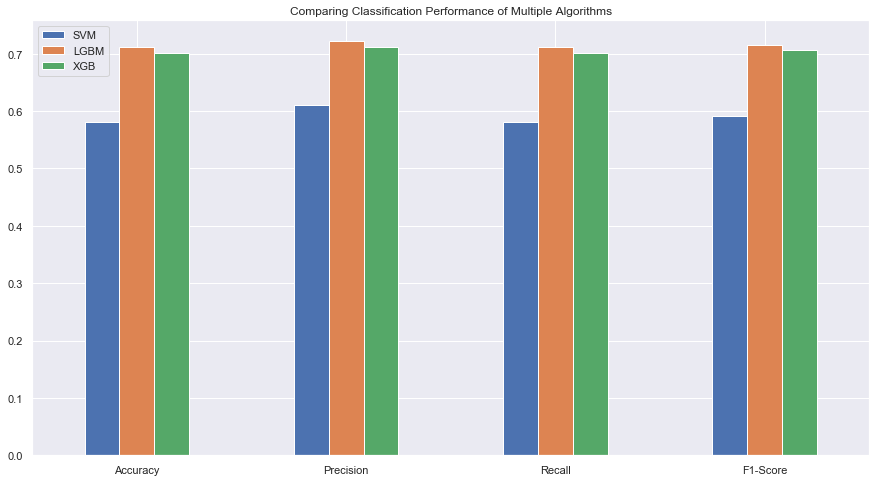

In [125]:
plt.rcParams["figure.figsize"] = (15,8)

df_models.plot.bar(edgecolor = "white")
plt.legend().set_visible(True)
plt.title("Comparing Classification Performance of Multiple Algorithms")
plt.xticks(rotation = 0)
plt.show()

### Conclusion

From the above, we can observe that **Light GBM** has the best performance compared to other algorithms at an overall level. 

#### For LGBM, which features are important for Fraud Identification

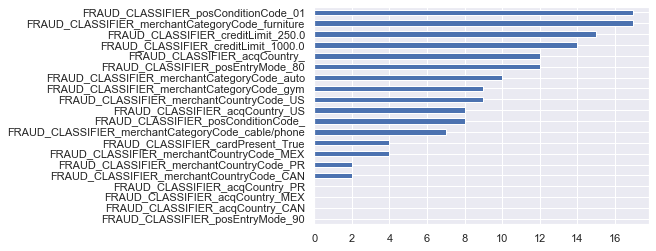

In [115]:
feat_importances = pd.Series(lgbm_model.feature_importances_, index=X_test.columns)
feat_importances.nsmallest(20).plot(kind='barh')
plt.show()

We can observe that the top 5 features for determining Fraud Transactions are:
* posConditionCode=01
* merchantCategoryCode="furniture"
* creditLimit=250
* creditLimit=1000
* acqCountry= " "